In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch_geometric.nn import Node2Vec
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import degree, to_networkx
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
sns.set()

In [68]:
anomalies_full_df_1 = pd.read_csv('final_upd_3.csv')
anomalies_full_df_1.drop('Unnamed: 0', axis =1, inplace = True)

In [23]:
anomalies_full_df = pd.read_csv('final_upd_2.csv')

In [25]:
anomalies_full_df.drop('Unnamed: 0', axis =1, inplace = True)

In [27]:
anomalies_full_df.head(5)

,gender,cust_id,age,tenure,betweenness_centrality,eigenvector_centrality,cash_sender_total_value,emt_sender_total_emt_value,emt_receiver_total_emt_value,wire_sender_total_wire_value,wire_sender_unique_countries_count,wire_receiver_total_wire_value,wire_receiver_unique_countries_count,anomaly_score,anomaly,occupation,degree,pagerank
0,female,CUST82758793,45.0,13.0,0.000166,6.211385e-06,-9.094947e-13,14412.0,11484.5,3971.5,1.0,0.0,0.0,-0.139738,-1,Architect,17.0,1.873905e-05
1,male,CUST69248708,52.0,8.0,0.000000,8.312449e-09,1.210000e+03,0.0,84.0,0.0,0.0,0.0,0.0,0.168741,1,Musician,1.0,6.048949e-07
2,female,CUST67222818,43.0,11.0,0.000433,2.592825e-05,3.835000e+03,4494.0,6538.5,28263.0,2.0,22629.5,2.0,-0.211307,-1,Jewelry Dealer,23.0,2.598257e-05
3,male,CUST33995820,35.0,17.0,0.000000,2.381742e-05,6.500000e+02,0.0,0.0,0.0,0.0,27385.0,1.0,-0.072102,-1,Optometrist,1.0,7.031788e-06
4,male,CUST76401392,39.0,21.0,0.000192,9.120898e-06,8.770000e+04,1147.5,18289.0,10429.0,1.0,23895.5,1.0,-0.197872,-1,Real Estate Broker,18.0,3.350476e-05


In [28]:
df_test = anomalies_full_df[['cust_id','betweenness_centrality','degree','eigenvector_centrality','pagerank']]
df_test.head(1)

,cust_id,betweenness_centrality,degree,eigenvector_centrality,pagerank
0,CUST82758793,0.000166,17.0,0.000006,0.000019


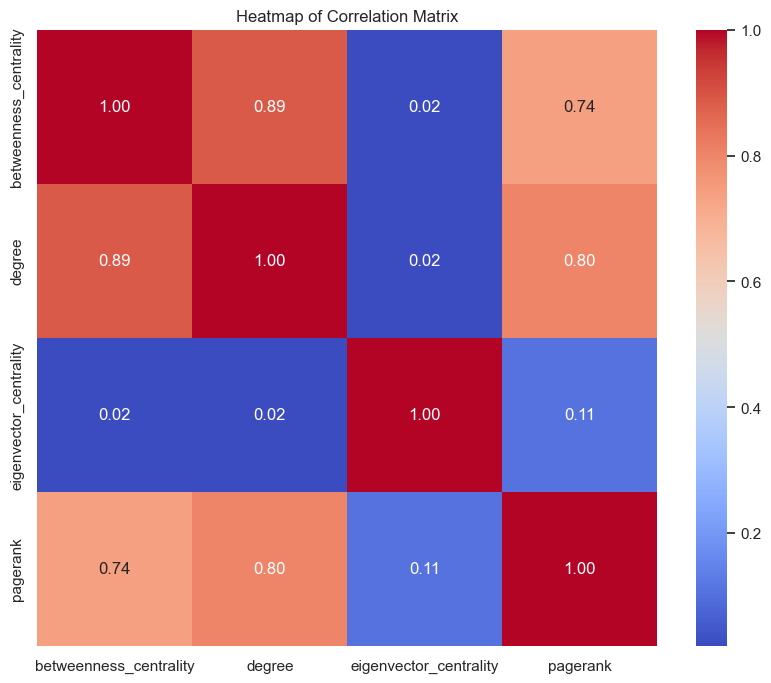

In [33]:
numerical_final_df = df_test.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for the numerical columns
corr_matrix = numerical_final_df.corr()

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # You can adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [34]:
for column in ['betweenness_centrality', 'degree', 'eigenvector_centrality', 'pagerank']:
    df_test[f'{column}_rank'] = df_test[column].rank(method='average',ascending = False)
df_test.head(1)

C:\Users\HP\AppData\Local\Temp\ipykernel_18532\3207263336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'{column}_rank'] = df_test[column].rank(method='average',ascending = False)
C:\Users\HP\AppData\Local\Temp\ipykernel_18532\3207263336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'{column}_rank'] = df_test[column].rank(method='average',ascending = False)
C:\Users\HP\AppData\Local\Temp\ipykernel_18532\3207263336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a 

,cust_id,betweenness_centrality,degree,eigenvector_centrality,pagerank,betweenness_centrality_rank,degree_rank,eigenvector_centrality_rank,pagerank_rank
0,CUST82758793,0.000166,17.0,0.000006,0.000019,8545.0,9554.5,9684.0,6312.0


In [35]:
df_test_sorted = df_test.sort_values(by=['degree_rank', 'betweenness_centrality_rank', 'eigenvector_centrality_rank', 'pagerank_rank'], ascending=True)
df_test_sorted.head(20)

,cust_id,betweenness_centrality,degree,eigenvector_centrality,pagerank,betweenness_centrality_rank,degree_rank,eigenvector_centrality_rank,pagerank_rank
169376,CUST45945736,0.000788,39.0,2.043833e-05,0.000046,11.0,1.0,4361.0,222.0
57313,CUST48479576,0.000887,36.0,7.827581e-06,0.000034,5.0,2.5,8417.0,979.0
137589,CUST70307829,0.000512,36.0,1.198185e-05,0.000029,230.0,2.5,6383.0,1985.0
17776,CUST18480796,0.000737,34.0,1.899192e-06,0.000021,21.0,5.5,18186.0,5091.0
90939,CUST38098328,0.000627,34.0,6.543835e-07,0.000027,65.0,5.5,29609.0,2522.0
76324,CUST96636430,0.000595,34.0,4.528923e-06,0.000031,95.0,5.5,11580.0,1557.0
33420,CUST17508188,0.000584,34.0,3.949161e-06,0.000023,107.0,5.5,12488.0,4086.0
116320,CUST59840809,0.000732,33.0,2.827950e-08,0.000007,22.0,14.0,81033.0,22800.0
29140,CUST42770982,0.000636,33.0,7.875073e-06,0.000026,58.0,14.0,8393.0,2653.0
98750,CUST42622757,0.000624,33.0,1.767454e-05,0.000044,67.0,14.0,4850.0,293.0


In [36]:
# High betweenness centrality nodes
high_betweenness_nodes = df_test[df_test['betweenness_centrality'] > df_test['betweenness_centrality'].quantile(0.9)]

In [37]:
# Normalizing centrality measures
for col in ['betweenness_centrality', 'degree', 'eigenvector_centrality', 'pagerank']:
    df_test[f'{col}_norm'] = (df_test[col] - df_test[col].min()) / (df_test[col].max() - df_test[col].min())

# Creating a composite score
df_test['composite_brokerage_score'] = df_test[['betweenness_centrality_norm', 'degree_norm', 'eigenvector_centrality_norm', 'pagerank_norm']].mean(axis=1)

# Identifying top brokerage nodes based on the composite score
top_brokerage_nodes = df_test.sort_values(by='composite_brokerage_score', ascending=False)
top_brokerage_nodes

C:\Users\HP\AppData\Local\Temp\ipykernel_18532\2436477744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'{col}_norm'] = (df_test[col] - df_test[col].min()) / (df_test[col].max() - df_test[col].min())
C:\Users\HP\AppData\Local\Temp\ipykernel_18532\2436477744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[f'{col}_norm'] = (df_test[col] - df_test[col].min()) / (df_test[col].max() - df_test[col].min())
C:\Users\HP\AppData\Local\Temp\ipykernel_18532\2436477744.py:3: SettingWithCopyWar

,cust_id,betweenness_centrality,degree,eigenvector_centrality,pagerank,betweenness_centrality_rank,degree_rank,eigenvector_centrality_rank,pagerank_rank,betweenness_centrality_norm,degree_norm,eigenvector_centrality_norm,pagerank_norm,composite_brokerage_score
188082,CUST36405209,0.000167,20.0,5.102206e-01,0.000142,8455.0,4778.5,1.0,1.0,0.178731,0.512821,1.000000,1.000000,0.672888
169376,CUST45945736,0.000788,39.0,2.043833e-05,0.000046,11.0,1.0,4361.0,222.0,0.843867,1.000000,0.000040,0.323601,0.541877
16289,CUST71866300,0.000416,24.0,1.478026e-01,0.000113,634.0,1229.0,5.0,3.0,0.445364,0.615385,0.289684,0.791945,0.535594
57313,CUST48479576,0.000887,36.0,7.827581e-06,0.000034,5.0,2.5,8417.0,979.0,0.949636,0.923077,0.000015,0.241124,0.528463
62775,CUST27817706,0.000568,28.0,1.579812e-03,0.000094,132.0,197.5,86.0,6.0,0.608570,0.717949,0.003096,0.660032,0.497412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98349,CUST90635127,0.000000,0.0,-1.694066e-21,0.000000,166750.0,181435.5,181237.0,181435.5,0.000000,0.000000,0.000000,0.000000,0.000000
98351,CUST28538463,0.000000,0.0,-1.694066e-21,0.000000,166750.0,181435.5,181237.0,181435.5,0.000000,0.000000,0.000000,0.000000,0.000000
98353,CUST45107115,0.000000,0.0,-1.694066e-21,0.000000,166750.0,181435.5,181237.0,181435.5,0.000000,0.000000,0.000000,0.000000,0.000000
98360,CUST89043536,0.000000,0.0,-1.694066e-21,0.000000,166750.0,181435.5,181237.0,181435.5,0.000000,0.000000,0.000000,0.000000,0.000000


In [202]:
top_1_percent_cutoff = top_brokerage_nodes['composite_brokerage_score'].quantile(0.999)  # Adjust quantile for different cutoffs
highly_influential_nodes = top_brokerage_nodes[top_brokerage_nodes['composite_brokerage_score'] >= top_1_percent_cutoff]

In [203]:
highly_influential_nodes

,cust_id,betweenness_centrality,degree,eigenvector_centrality,pagerank,betweenness_centrality_rank,degree_rank,eigenvector_centrality_rank,pagerank_rank,betweenness_centrality_norm,degree_norm,eigenvector_centrality_norm,pagerank_norm,composite_brokerage_score
188082,CUST36405209,0.000167,20.0,0.510221,0.000142,8455.0,4778.5,1.0,1.0,0.178731,0.512821,1.000000,1.000000,0.672888
169376,CUST45945736,0.000788,39.0,0.000020,0.000046,11.0,1.0,4361.0,222.0,0.843867,1.000000,0.000040,0.323601,0.541877
16289,CUST71866300,0.000416,24.0,0.147803,0.000113,634.0,1229.0,5.0,3.0,0.445364,0.615385,0.289684,0.791945,0.535594
57313,CUST48479576,0.000887,36.0,0.000008,0.000034,5.0,2.5,8417.0,979.0,0.949636,0.923077,0.000015,0.241124,0.528463
62775,CUST27817706,0.000568,28.0,0.001580,0.000094,132.0,197.5,86.0,6.0,0.608570,0.717949,0.003096,0.660032,0.497412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26656,CUST88514959,0.000685,22.0,0.000006,0.000021,28.0,2582.5,9804.0,5013.0,0.733148,0.564103,0.000012,0.146551,0.360953
162480,CUST16778561,0.000665,24.0,0.000003,0.000016,39.0,1229.0,15733.0,8059.0,0.712514,0.615385,0.000005,0.115590,0.360874
85758,CUST78988833,0.000509,26.0,0.000014,0.000033,236.0,530.0,5879.0,1176.0,0.545121,0.666667,0.000027,0.231345,0.360790
100283,CUST21163812,0.000314,31.0,0.000008,0.000044,1912.0,36.5,8583.0,284.0,0.335936,0.794872,0.000015,0.310770,0.360398


In [204]:
anomalies_df = anomalies_full_df_1[anomalies_full_df_1.anomaly == -1]
df_merged = anomalies_df.merge(highly_influential_nodes[['cust_id','composite_brokerage_score']], how = 'inner', on = 'cust_id')
df_merged

,gender,cust_id,age,tenure,cash_sender_total_value,emt_sender_total_emt_value,emt_receiver_total_emt_value,wire_sender_total_wire_value,wire_sender_unique_countries_count,wire_receiver_total_wire_value,wire_receiver_unique_countries_count,anomaly_score,anomaly,occupation,composite_brokerage_score
0,male,CUST98901965,35.0,2.0,2.914000e+04,17696.0,9827.0,40554.0,3.0,8231.0,1.0,-0.243765,-1,Music Producer,0.432137
1,male,CUST71268159,48.0,17.0,-9.094947e-13,15325.0,11376.0,0.0,0.0,200204.0,1.0,-0.220992,-1,Private Security Company Owner,0.428443
2,female,CUST94760680,52.0,2.0,4.125000e+03,6471.5,13717.0,2571.5,1.0,8934.5,2.0,-0.167607,-1,Unemployed,0.392669
3,female,CUST26911489,36.0,14.0,5.184000e+04,5869.5,6799.5,2244.0,1.0,0.0,0.0,-0.089581,-1,Property Manager,0.377191
4,male,CUST48605422,53.0,13.0,-9.094947e-13,8836.5,10344.5,1457.5,1.0,2077.0,2.0,-0.144951,-1,Maritime or Shipping Agent,0.365497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,male,CUST73212501,18.0,0.0,-9.094947e-13,7839.0,9230.5,12567.0,1.0,18440.0,1.0,-0.142013,-1,Civil Servant,0.366664
189,female,CUST36405209,54.0,11.0,-9.094947e-13,1797.0,3376.0,747318.0,2.0,11027.0,1.0,-0.203404,-1,Miner,0.672888
190,male,CUST17148894,25.0,7.0,6.871000e+04,5775.5,20647.5,2175.0,1.0,28833.0,2.0,-0.199997,-1,Shell Company Operator,0.385254
191,male,CUST41581393,42.0,9.0,-9.094947e-13,14912.5,6718.0,35860.5,2.0,43620.5,1.0,-0.248203,-1,Precious Metals Dealer,0.394555


In [214]:
influential_customers = df_merged.cust_id.tolist()

In [215]:
#influential_customers = influential_customers[-20:]

In [216]:
len(influential_customers)

193

In [72]:
# Load the provided CSV files
kyc_path = 'kyc.csv'
cash_trxns_path = 'cash_trxns.csv'
emt_trxns_path = 'emt_trxns.csv'
wire_trxns_path = 'wire_trxns.csv'

# Read the data
kyc_data = pd.read_csv(kyc_path).drop(columns=['label'])  # Dropping 'label' as instructed
cash_trxns_data = pd.read_csv(cash_trxns_path)
emt_trxns_data = pd.read_csv(emt_trxns_path)
wire_trxns_data = pd.read_csv(wire_trxns_path)

In [73]:
cash_trxns_data['transaction_type'] = 'cash'
emt_trxns_data['transaction_type'] = 'emt'
wire_trxns_data['transaction_type'] = 'wire'

# Rename columns for uniformity
emt_trxns_data.rename(columns={'id sender': 'cust_id_sender', 'id receiver': 'cust_id_receiver', 'emt value': 'amount'}, inplace=True)
wire_trxns_data.rename(columns={'id sender': 'cust_id_sender', 'id receiver': 'cust_id_receiver', 'wire value': 'amount'}, inplace=True)
cash_trxns_data.rename(columns={'cust_id': 'cust_id_sender', 'value': 'amount'}, inplace=True)

In [243]:
transactions_combined = pd.concat([
    cash_trxns_data[['cust_id_sender', 'amount', 'transaction_type']],
    emt_trxns_data[['cust_id_sender', 'cust_id_receiver', 'amount', 'transaction_type']],
    wire_trxns_data[['cust_id_sender', 'cust_id_receiver', 'amount', 'transaction_type']]
], ignore_index=True)
transactions_combined['cust_id_receiver'].fillna('NoReceiver', inplace=True)
transactions_combined = transactions_combined[transactions_combined['transaction_type'] != 'cash']
transactions_combined = transactions_combined.groupby(['cust_id_sender','cust_id_receiver'])['amount'].sum().reset_index()
transactions_combined.to_csv('transactions_combined.csv')

In [236]:
filtered_transactions = transactions_combined[
    transactions_combined['cust_id_sender'].isin(influential_customers) |
    transactions_combined['cust_id_receiver'].isin(influential_customers)
]

transactions_grouped = filtered_transactions.groupby(['cust_id_sender', 'cust_id_receiver'])['amount'].sum().reset_index()

In [238]:
len(transactions_grouped)

5254

In [239]:
import pandas as pd
import networkx as nx


G = nx.Graph()

# Add edges to the graph from the transactions DataFrame
for _, transaction in transactions_grouped.iterrows():
    sender_id = transaction['cust_id_sender']
    receiver_id = transaction['cust_id_receiver']
    amount = transaction['amount']  # Assuming this is how you wish to use the transaction amount, e.g., as edge weight
    
    # Add edge with the amount as edge attribute (weight)
    G.add_edge(sender_id, receiver_id, weight=amount)

In [240]:
len(G)

5288

In [241]:
for cust_id in influential_customers:
    if cust_id in G:  # Check if the customer is in the graph
        G.nodes[cust_id]['influential'] = True

# Drawing the graph
plt.figure(figsize=(12, 8))

# Node colors: 'red' for influential customers, 'blue' for others
node_colors = ['red' if G.nodes[node].get('influential') else 'blue' for node in G.nodes]

# Using the spring layout for positioning
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

plt.title('Network Graph of Transactions')
plt.axis('off')  # Turn off the axis
plt.show()


KeyboardInterrupt



In [196]:
len(nodes_to_include)

251007

In [232]:
import networkx as nx

nodes_to_include = set(influential_customers)

for customer in influential_customers:
    # Get direct neighbors of 'customer'
    neighbors = set(G.neighbors(customer))
    
    # Add these neighbors to our set
    nodes_to_include.update(neighbors)

subG_direct = G.subgraph(nodes_to_include)

In [233]:
len(influential_customers)

193

In [242]:
len(subG_direct)

4855

In [217]:
# Assuming influential_customers is a list of customer IDs
nodes_to_include = set(influential_customers)
distance = 4 # Adjust based on how "far" you want to go in terms of indirect connections

for customer in influential_customers:
    # BFS to get all nodes within 'distance' steps from 'customer'
    bfs_nodes = nx.single_source_shortest_path_length(G, customer,distance)
    
    # Add these nodes to our set
    nodes_to_include.update(bfs_nodes.keys())

subG_indirect = G.subgraph(nodes_to_include)

In [222]:
edges = list(subG_indirect.edges(data=True))  # List of edges with data
edges_df_pd = pd.DataFrame(edges, columns=['source', 'target', 'data'])

# Convert graph nodes to a pandas DataFrame
nodes = list(subG_indirect.nodes(data=True))  # List of nodes with data
nodes_df_pd = pd.DataFrame(nodes, columns=['node', 'data'])

In [223]:
# Node sizes based on brokerage score or a default value for non-influential nodes
node_sizes = [df_merged.loc[df_merged['cust_id'] == node, 'composite_brokerage_score'].values[0]*100 if node in influential_customers else 50 for node in subG_indirect.nodes()]

# Node colors: red for influential, blue for others
node_colors = ['red' if node in influential_customers else 'grey' for node in subG_indirect.nodes()]